# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1DnLhQg428BK2kgqZhBAmQZ-Nv7Ztv5tS?usp=sharing

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab2_Cats_vs_Dogs.ipynb


[NbConvertApp] Converting notebook /content/Lab2_Cats_vs_Dogs.ipynb to html
[NbConvertApp] Writing 1757863 bytes to /content/Lab2_Cats_vs_Dogs.html


In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

100%|██████████| 170498071/170498071 [00:01<00:00, 101451035.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
8000
2000
2000


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

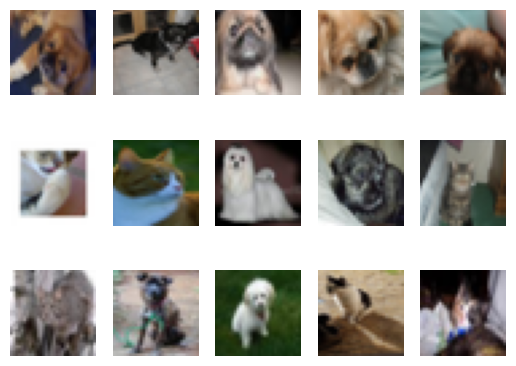

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?


The number of Training examples for the combiend cat and dog classes: 8000

The number of Validation Examples for the combined cat and dog classes: 2000

The number of Test Examples for the combined cat and dog classes: 2000





### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

We need a Validation Set when training our model for validating the training result on the new and unseen data and tuning hyper-parameters.

Judging the performance on training set loss/error can not imply it's behaviour on unseen data becuase it has optimized its behaviour on seen data, the model would lead to overfitting on the training data if only training set loss/error is concerned.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
small_net_size = 0
for param in small_net.parameters():
    print(param.shape)
    small_net_size+=param.numel()
print("Total number for parameters in small_net is", small_net_size)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
Total number for parameters in small_net is 386


In [ ]:
large_net_size = 0
for param in large_net.parameters():
    print(param.shape)
    large_net_size+=param.numel()
print("Total number for parameters in large_net is", large_net_size)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
Total number for parameters in large_net is 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

batch_size=64

learning_rate=0.01

num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net, num_epochs = 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.422875, Train loss: 0.6721769604682922 |Validation err: 0.37, Validation loss: 0.6553402673453093
Epoch 2: Train err: 0.36225, Train loss: 0.6437541437149048 |Validation err: 0.3695, Validation loss: 0.6521072052419186
Epoch 3: Train err: 0.346375, Train loss: 0.6297389397621155 |Validation err: 0.339, Validation loss: 0.6248400881886482
Epoch 4: Train err: 0.33825, Train loss: 0.6165760045051575 |Validation err: 0.3665, Validation loss: 0.6343626752495766
Epoch 5: Train err: 0.328125, Train loss: 0.6074858188629151 |Validation err: 0.337, Validation loss: 0.6195144839584827
Finished Training
Total time elapsed: 23.92 seconds


Epoch 1: Train err: 0.278375, Train loss: 0.5464853410720825 |Validation err: 0.3045, Validation loss: 0.5825032154098153

current model (checkpoint) for epoch 1 is saved into file: model_small_bs64_lr0.01_epoch0

Epoch 2: Train err: 0.275625, Train loss: 0.5457877469062805 |Validation err: 0.31, Validation loss: 0.5907086320221424

current model (checkpoint) for epoch 2 is saved into file: model_small_bs64_lr0.01_epoch1

Epoch 3: Train err: 0.27525, Train loss: 0.5458775641918182 |Validation err: 0.301, Validation loss: 0.5823545632883906

current model (checkpoint) for epoch 3 is saved into file: model_small_bs64_lr0.01_epoch2

Epoch 4: Train err: 0.27925, Train loss: 0.5470323100090027 |Validation err: 0.3085, Validation loss: 0.5924761239439249

current model (checkpoint) for epoch 4 is saved into file: model_small_bs64_lr0.01_epoch3

Epoch 5: Train err: 0.275375, Train loss: 0.5463326833248139 |Validation err: 0.2995, Validation loss: 0.5859779678285122

current model (checkpoint) for epoch 5 is saved into file: model_small_bs64_lr0.01_epoch4

Train Error is saved into CSV file:  model_small_bs64_lr0.01_epoch4_train_err.csv

Train Loss is saved into CSV file:  model_small_bs64_lr0.01_epoch4_train_loss.csv

Validation Error is saved into CSV file:  model_small_bs64_lr0.01_epoch4_val_err.csv

Validation Loss is saved into CSV file:  model_small_bs64_lr0.01_epoch4_val_loss.csv

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
small_net = SmallNet()
large_net = LargeNet()
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.446375, Train loss: 0.6813716783523559 |Validation err: 0.3865, Validation loss: 0.6602997500449419
Epoch 2: Train err: 0.37325, Train loss: 0.6497629323005676 |Validation err: 0.3845, Validation loss: 0.6575995869934559
Epoch 3: Train err: 0.359875, Train loss: 0.6388978385925292 |Validation err: 0.3495, Validation loss: 0.6291275043040514
Epoch 4: Train err: 0.346375, Train loss: 0.6246587996482849 |Validation err: 0.356, Validation loss: 0.6221408396959305
Epoch 5: Train err: 0.334375, Train loss: 0.6153830280303955 |Validation err: 0.3275, Validation loss: 0.6188967823982239
Epoch 6: Train err: 0.318, Train loss: 0.6036732516288758 |Validation err: 0.339, Validation loss: 0.6094125052914023
Epoch 7: Train err: 0.315625, Train loss: 0.5944745948314667 |Validation err: 0.329, Validation loss: 0.5974238961935043
Epoch 8: Train err: 0.3085, Train loss: 0.5829453563690186 |Validation err: 0

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.454375, Train loss: 0.6898944606781006 |Validation err: 0.4205, Validation loss: 0.6793290264904499
Epoch 2: Train err: 0.418875, Train loss: 0.6788924961090088 |Validation err: 0.4215, Validation loss: 0.6790428329259157
Epoch 3: Train err: 0.40525, Train loss: 0.6685061388015747 |Validation err: 0.3905, Validation loss: 0.6528578028082848
Epoch 4: Train err: 0.379125, Train loss: 0.6512472186088561 |Validation err: 0.3935, Validation loss: 0.6531118471175432
Epoch 5: Train err: 0.35525, Train loss: 0.6316115870475769 |Validation err: 0.3465, Validation loss: 0.6301526054739952
Epoch 6: Train err: 0.33675, Train loss: 0.6122225694656372 |Validation err: 0.352, Validation loss: 0.6261688079684973
Epoch 7: Train err: 0.3215, Train loss: 0.5984608561992645 |Validation err: 0.3475, Validation loss: 0.6187550257891417
Epoch 8: Train err: 0.31425, Train loss: 0.5851289410591125 |Validation err:

Total time elapsed for training small_net: 144.36 seconds

Total time elapsed for training large_net: 160.92 seconds


Time for training large_net takes longer because large_net have more parameters and such result in a larger network to train, taking longer time to train.


### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

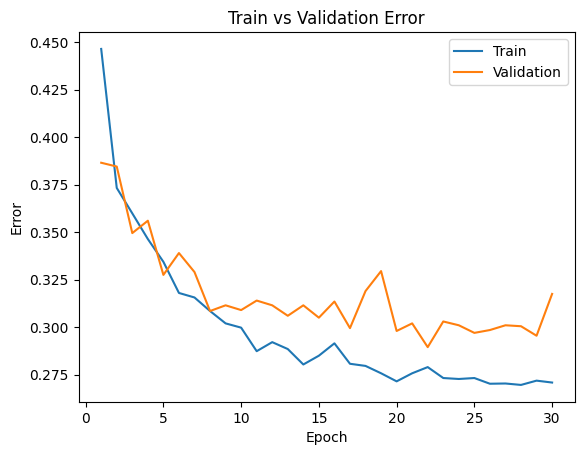

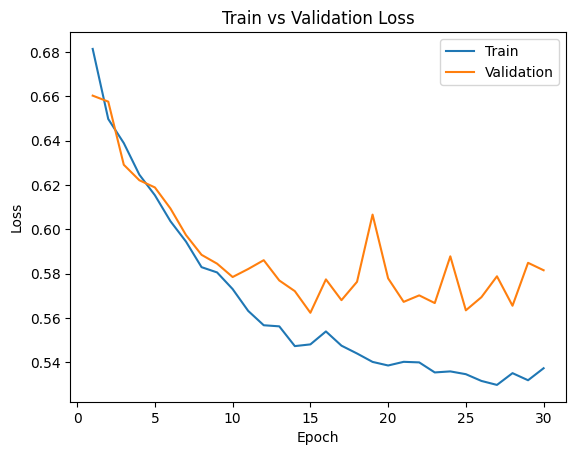

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

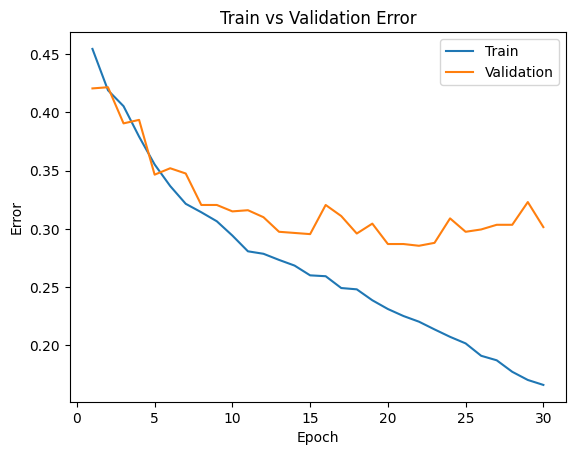

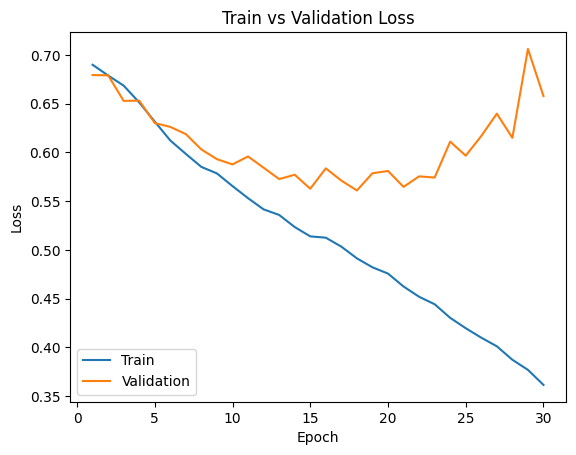

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

Both Validation and Training are decreasing in error as the number of epoch increases.

In both early stages, training and validating loss decreases as the number of epoch increases, indicating the model is underfitting in the early stanges.

Comparing to small net, where the validation and testing loss and error is approaching a constant value, large net is experiencing overfitting at the end of the training as seen from the graph that large net validation loss is diverging from training loss, increasing in value. In addition, from the error graph, one can see that validating error slowly starts to increase, indicating overfitting.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

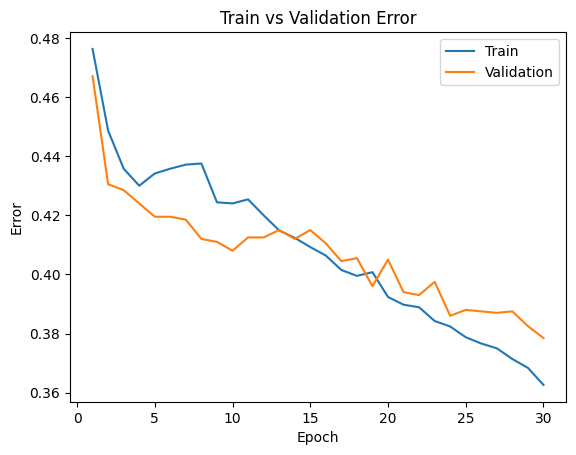

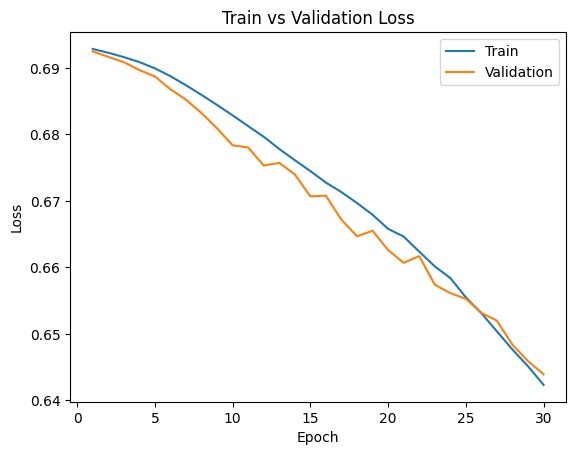

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)

Training time increases for around 2 seconds as learning rate decreases. This is because lowering the learning rate model update gradient descent more slowly. But overall the training time did not significantly increase, training time is still around the same number.

In addition, the step size for updating gradient descent for the default learning_rate = 0.01 is too big, leading to overfitting. For learning_rate = 0.001, the model did not overfit at the end of 29 epoch training. Eventhough for 29 epoch, the loss and error for both training and validation is much higher because the step size is small.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

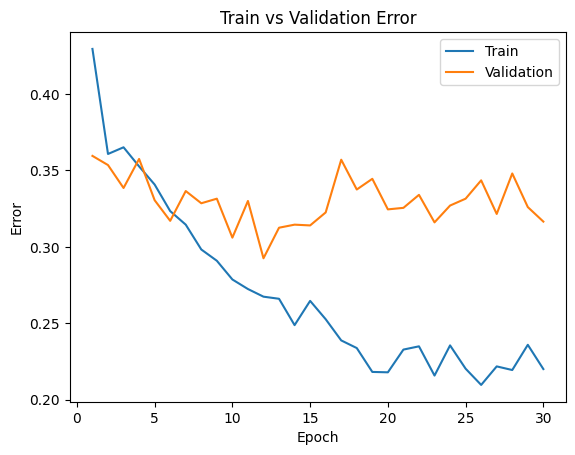

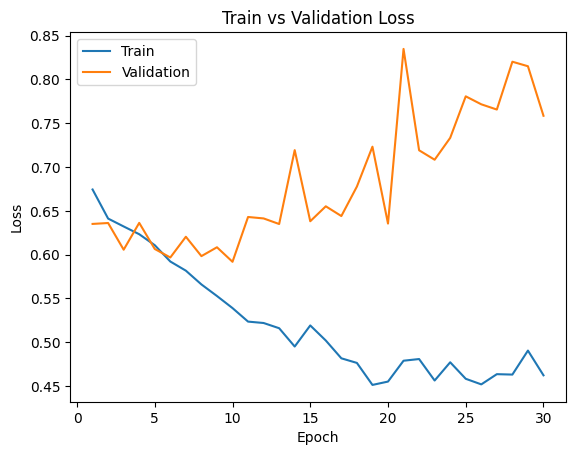

In [ ]:
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

The training time when learning_rate increased to 0.1 is roughly the same time as it takes for the default parameters. Compared to default parameter, the step size for gradient descent update is bigger. The model overfits already for the default parameter, so when learning_rate is changed to 0.1, it overfits faster. In addition the underfitting portion at the start of the training decreases in epoch as the step size for gradient descent is bigger.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.01, batch_size = 512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

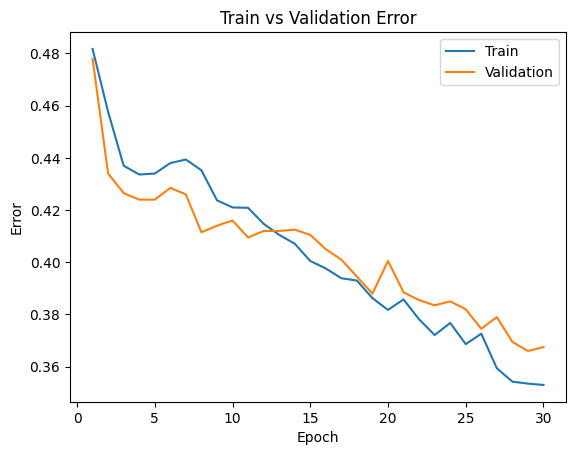

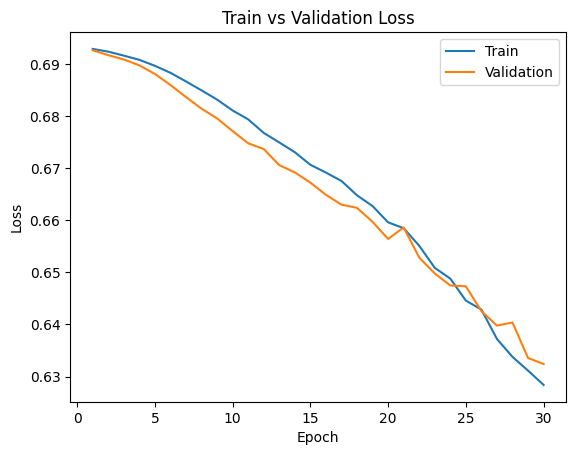

In [ ]:
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

As the batch size increases, the training time decreases for around 20 seconds. This is caused by increasing the batch size decreases the number of iterations needed. Thus decreasing the training time. However, increasing the batch size also increase in tranining and validation loss and error as the number of iterations decreases. The model is also not overfitting because there is less iterations.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.01, batch_size = 16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

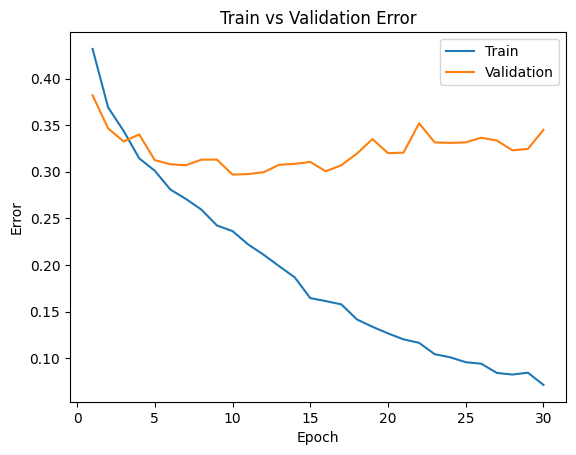

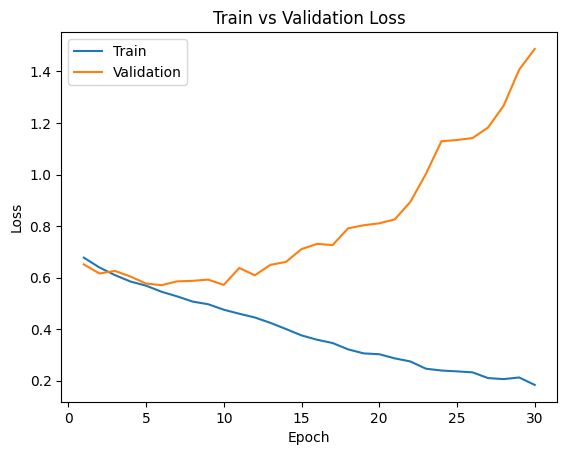

In [ ]:
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

As the batch size decreases, the training time increases for around 60 seconds. This is caused by decreasing the batch size increases the number of iterations needed. Thus increasing the training time. In general, training and validation error will be smaller because of the increase in number of iterations. However, since the model is overfitting already with the default parameter, increases the batch size leads to more overfitting for validation loss.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I choose large_net because the amount of parameter is larger, making the network easier to capture more feature in the data and resulting in better training result. My main goal is to decrease the chance of overfitting at 29 epoch. I would increase the batch size to 256 to minimize the chances of overfitting.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.01, batch_size = 256)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.467625, Train loss: 0.6926687750965357 |Validation err: 0.4355, Validation loss: 0.6918838396668434
Epoch 2: Train err: 0.45125, Train loss: 0.6913921367377043 |Validation err: 0.446, Validation loss: 0.6896143183112144
Epoch 3: Train err: 0.428375, Train loss: 0.6892956402152777 |Validation err: 0.418, Validation loss: 0.6862075850367546
Epoch 4: Train err: 0.432375, Train loss: 0.6857246868312359 |Validation err: 0.4185, Validation loss: 0.6810905262827873
Epoch 5: Train err: 0.425875, Train loss: 0.6823424641042948 |Validation err: 0.414, Validation loss: 0.6774001196026802
Epoch 6: Train err: 0.41775, Train loss: 0.6785750649869442 |Validation err: 0.415, Validation loss: 0.6732205599546432
Epoch 7: Train err: 0.4085, Train loss: 0.6743601486086845 |Validation err: 0.412, Validation loss: 0.6696006879210472
Epoch 8: Train err: 0.401625, Train loss: 0.6709103956818581 |Validation err: 0

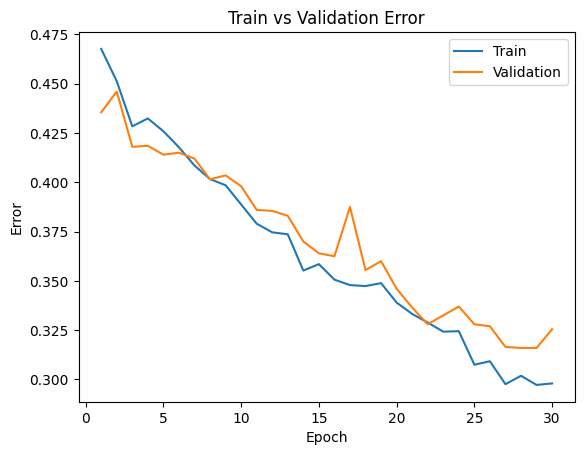

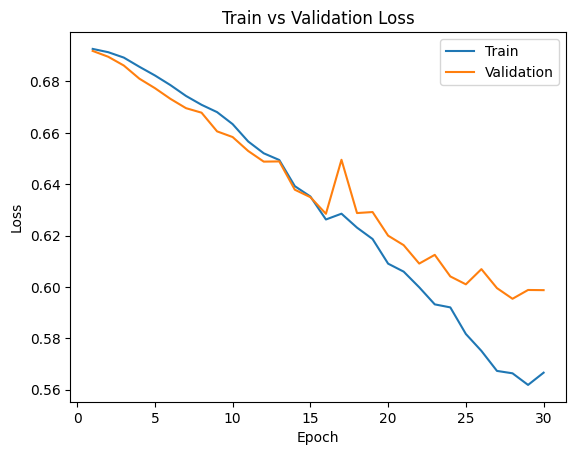

In [ ]:
model_path = get_model_name("large", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

changing the batch size to 256 successfully prevents the model from overfitting. However it now underfits. Thus I would tune the learning rate to a bigger value to allow bigger step size for updating. However from part (b) from the previous section one can see that changing learning_rate to 0.1 results in a great amount of over fitting. I would increase the learning rate to 0.0115.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net,learning_rate = 0.0115, batch_size = 256)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.46725, Train loss: 0.6926107853651047 |Validation err: 0.4315, Validation loss: 0.6917001232504845
Epoch 2: Train err: 0.452875, Train loss: 0.6911133918911219 |Validation err: 0.439, Validation loss: 0.6889409273862839
Epoch 3: Train err: 0.429875, Train loss: 0.6884810235351324 |Validation err: 0.4195, Validation loss: 0.6844424158334732
Epoch 4: Train err: 0.429875, Train loss: 0.6841822788119316 |Validation err: 0.4105, Validation loss: 0.6788032203912735
Epoch 5: Train err: 0.4195, Train loss: 0.6802280060946941 |Validation err: 0.415, Validation loss: 0.6747560054063797
Epoch 6: Train err: 0.41375, Train loss: 0.6757875289767981 |Validation err: 0.414, Validation loss: 0.6709291562438011
Epoch 7: Train err: 0.403, Train loss: 0.6712961960583925 |Validation err: 0.404, Validation loss: 0.6678921729326248
Epoch 8: Train err: 0.395375, Train loss: 0.6672680992633104 |Validation err: 0.3

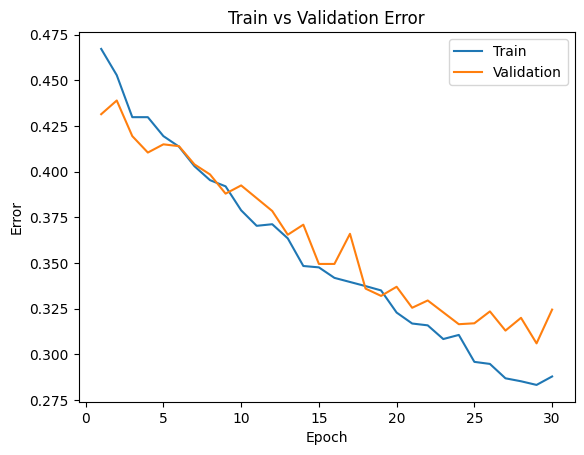

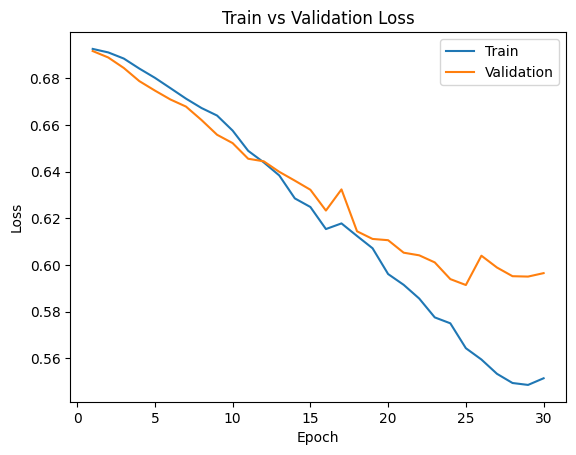

In [ ]:
model_path = get_model_name("large", batch_size=256, learning_rate=0.0115, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.0115, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

I choose large_net because the amount of parameter is bigger, making the network easier to capture more feature in the data and resulting in better training result. My main goal is to decrease the chance of overfitting at 29 epoch. I would increase the batch size to 256 to minimize the chances of overfitting.

changing the batch size to 256 successfully prevents the model from overfitting. However it now underfits. Thus I would tune the learning rate to a bigger value to allow bigger step size for updating. However from part (b) from the previous section one can see that changing learning_rate to 0.1 results in a great amount of over fitting. I would increase the learning rate to 0.0115.



### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(net, test_loader, criterion)
print("test classification error is", err)
print("test classification loss is", loss)

Files already downloaded and verified
Files already downloaded and verified
test classification error is 0.305
test classification loss is 0.5736809149384499


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

My test classification error is very similar to validation error seen. Test error is around 0.305 and test loss is around 0.57. validation error is around 0.3 while validation loss is around 0.6. Eventhough it is similar for my data, theoritically test error should be higher than validation error because test dataset are a new set of data that is used for testing while the model have tuned the parameter based on validation dataset. So the model's behaviour on the testing dataset should be worse than validation dataset.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Only if test data is given as an unseen set of data can generate the actual error and loss of the model's behaviour on unseen dataset. It is important that we use the test data as little as possible to ensure the model is not trained with test data before, enableing better error and loss on unseen data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(3* 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3* 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = activation2.squeeze(1)
        return activation2



Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.421875, Train loss: 0.6742314118891954 |Validation err: 0.3945, Validation loss: 0.6581188961863518
Epoch 2: Train err: 0.38075, Train loss: 0.6503762304782867 |Validation err: 0.39, Validation loss: 0.6518373042345047
Epoch 3: Train err: 0.371, Train loss: 0.638554971665144 |Validation err: 0.38, Validation loss: 0.6489328742027283
Epoch 4: Train err: 0.358875, Train loss: 0.6303329616785049 |Validation err: 0.3875, Validation loss: 0.6505187973380089
Epoch 5: Train err: 0.353, Train loss: 0.6234526932239532 |Validation err: 0.379, Validation loss: 0.645306259393692
Epoch 6: Train err: 0.340125, Train loss: 0.617022329941392 |Validation err: 0.379, Validation loss: 0.6477555707097054
Epoch 7: Train err: 0.336625, Train loss: 0.6100924145430326 |Validation err: 0.374, Validation loss: 0.6435356959700584
Epoch 8: Train err: 0.32775, Train loss: 0.6041284166276455 |Validation err: 0.374, Val

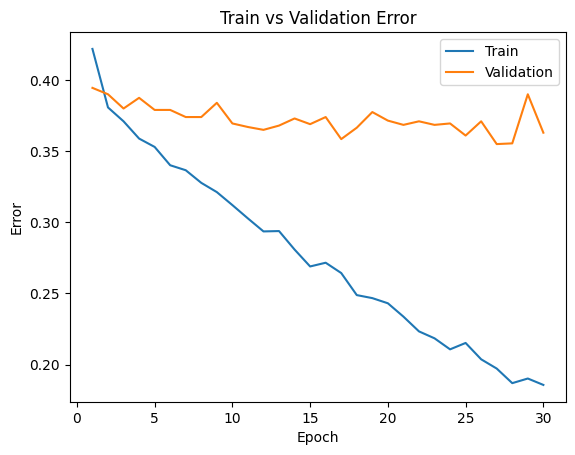

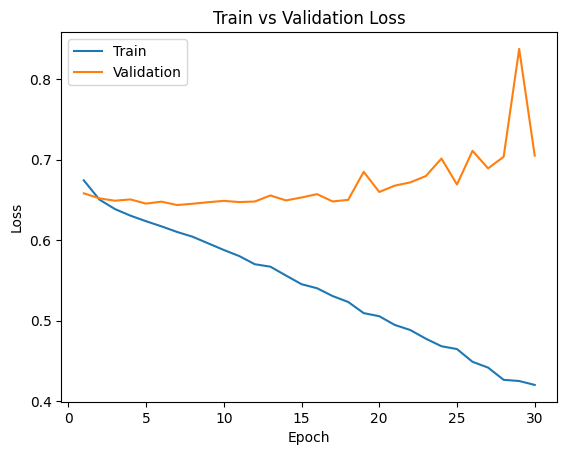

In [ ]:
ANN = ANN()
train_net(ANN,batch_size=256, learning_rate=0.01)
model_path = get_model_name("ANN", batch_size=256, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)
criterion = nn.BCEWithLogitsLoss()
err, loss = evaluate(ANN, test_loader, criterion)
print("test classification error is", err)
print("test classification loss is", loss)

Files already downloaded and verified
Files already downloaded and verified
test classification error is 0.36
test classification loss is 0.6949786022305489


Comparing to ANN, CNN have better behaviour in both test classification error and test classification loss. Thus my best CNN model compare is better than a 2-layer ANN model (no convolutional layers) on classifying cat and dog images.